# Data Augmentation

In [1]:
import tensorflow as tf
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers, losses, metrics

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.optimizers import RMSprop

import numpy as np
import matplotlib.pyplot as plt
import PIL
import os

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# 데이터셋 디렉터리 경로
dataset_dir = '/content/drive/MyDrive/dataset_real'

# 사진 크기
image_height = 224
image_width = 224
batch_size = 32



train_ds = tf.keras.utils.image_dataset_from_directory(
  dataset_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(image_height, image_width),
  batch_size=batch_size)

val_ds = tf.keras.utils.image_dataset_from_directory(
  dataset_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(image_height, image_width),
  batch_size=batch_size)



# 훈련셋에서 배치를 생성
for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

Found 1006 files belonging to 4 classes.
Using 805 files for training.
Found 1006 files belonging to 4 classes.
Using 201 files for validation.
(32, 224, 224, 3)
(32,)


# Model 1 (VGG16)

In [4]:
preprocess_input = tf.keras.applications.vgg16.preprocess_input

IMG_SHAPE = (image_height, image_width) + (3,)
base_model = VGG16(input_shape=IMG_SHAPE,
                   include_top=False,
                   weights='imagenet')



normalization_layer = layers.Rescaling(1./255)
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
feature_batch = base_model(image_batch)

base_model.trainable = False
base_model.summary()

58900480/58889256 [==============================] - 1s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                              

In [5]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)

prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)

In [6]:
inputs = tf.keras.Input(shape=IMG_SHAPE)
# x = data_augmentation(inputs)
x = preprocess_input(inputs)
x = base_model(x, training=False)
x = global_average_layer(x)
# x = layers.Dropout(0.2)(x)
outputs = layers.Dense(1, activation='linear')(x)

model = tf.keras.Model(inputs, outputs)

In [7]:
base_learning_rate = 0.0001
model.compile(optimizer = tf.keras.optimizers.RMSprop(lr=base_learning_rate),
              loss = 'mse',
              metrics = ['mae'])

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.__operators__.getitem (S  (None, 224, 224, 3)      0         
 licingOpLambda)                                                 
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 224, 224, 3)      0         
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 global_average_pooling2d (G  (None, 512)              0         
 lobalAveragePooling2D)                                          
                                                                 
 dense_1 (Dense)             (None, 1)                 513   

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


In [8]:
initial_epochs = 10

history = model.fit_generator(train_ds,
                              epochs=initial_epochs,
                              validation_data=val_ds)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  """


Epoch 1/10
26/26 [==============================] - 91s 3s/step - loss: 6.1390 - mae: 1.8940 - val_loss: 5.6105 - val_mae: 1.8729
Epoch 2/10
26/26 [==============================] - 8s 309ms/step - loss: 5.5924 - mae: 1.8200 - val_loss: 5.4471 - val_mae: 1.8465
Epoch 3/10
26/26 [==============================] - 9s 311ms/step - loss: 5.2677 - mae: 1.7748 - val_loss: 5.1424 - val_mae: 1.7943
Epoch 4/10
26/26 [==============================] - 8s 310ms/step - loss: 4.9648 - mae: 1.7204 - val_loss: 4.9307 - val_mae: 1.7549
Epoch 5/10
26/26 [==============================] - 9s 314ms/step - loss: 4.6809 - mae: 1.6732 - val_loss: 4.6711 - val_mae: 1.7061
Epoch 6/10
26/26 [==============================] - 9s 311ms/step - loss: 4.4215 - mae: 1.6275 - val_loss: 4.4477 - val_mae: 1.6653
Epoch 7/10
26/26 [==============================] - 9s 312ms/step - loss: 4.1981 - mae: 1.5858 - val_loss: 4.2205 - val_mae: 1.6266
Epoch 8/10
26/26 [==============================] - 9s 313ms/step - loss: 4.00

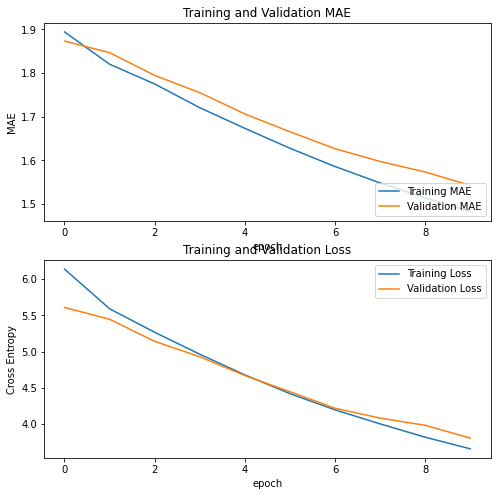

In [9]:
mae = history.history['mae']
val_mae = history.history['val_mae']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(mae, label='Training MAE')
plt.plot(val_mae, label='Validation MAE')
plt.legend(loc='lower right')
plt.xlabel('epoch')
plt.ylabel('MAE')
plt.title('Training and Validation MAE')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.xlabel('epoch')
plt.ylabel('Cross Entropy')
plt.title('Training and Validation Loss')
plt.show()

# Model 2 (VGG19)

In [10]:
preprocess_input = tf.keras.applications.vgg19.preprocess_input

IMG_SHAPE = (image_height, image_width) + (3,)
base_model = VGG19(input_shape=IMG_SHAPE,
                   include_top=False,
                   weights='imagenet')



normalization_layer = layers.Rescaling(1./255)
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
feature_batch = base_model(image_batch)

base_model.trainable = False
base_model.summary()

80150528/80134624 [==============================] - 1s 0us/step
Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                              

In [11]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)

prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)

In [12]:
inputs = tf.keras.Input(shape=IMG_SHAPE)
# x = data_augmentation(inputs)
x = preprocess_input(inputs)
x = base_model(x, training=False)
x = global_average_layer(x)
# x = layers.Dropout(0.2)(x)
outputs = layers.Dense(1, activation='linear')(x)

model = tf.keras.Model(inputs, outputs)

In [13]:
base_learning_rate = 0.0001
model.compile(optimizer = tf.keras.optimizers.RMSprop(lr=base_learning_rate),
              loss = 'mse',
              metrics = ['mae'])

model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.__operators__.getitem_1   (None, 224, 224, 3)      0         
 (SlicingOpLambda)                                               
                                                                 
 tf.nn.bias_add_1 (TFOpLambd  (None, 224, 224, 3)      0         
 a)                                                              
                                                                 
 vgg19 (Functional)          (None, 7, 7, 512)         20024384  
                                                                 
 global_average_pooling2d_1   (None, 512)              0         
 (GlobalAveragePooling2D)                                        
                                                           

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


In [14]:
initial_epochs = 10

history = model.fit_generator(train_ds,
                              epochs=initial_epochs,
                              validation_data=val_ds)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  """


Epoch 1/10
26/26 [==============================] - 11s 379ms/step - loss: 14.8767 - mae: 3.0778 - val_loss: 11.8978 - val_mae: 2.5926
Epoch 2/10
26/26 [==============================] - 10s 367ms/step - loss: 8.2888 - mae: 2.1698 - val_loss: 7.3318 - val_mae: 1.9778
Epoch 3/10
26/26 [==============================] - 10s 366ms/step - loss: 5.2071 - mae: 1.6844 - val_loss: 5.4453 - val_mae: 1.7232
Epoch 4/10
26/26 [==============================] - 10s 367ms/step - loss: 4.1723 - mae: 1.5334 - val_loss: 4.7796 - val_mae: 1.6332
Epoch 5/10
26/26 [==============================] - 10s 365ms/step - loss: 3.8669 - mae: 1.4961 - val_loss: 4.5345 - val_mae: 1.5994
Epoch 6/10
26/26 [==============================] - 10s 365ms/step - loss: 3.6891 - mae: 1.4676 - val_loss: 4.3618 - val_mae: 1.5735
Epoch 7/10
26/26 [==============================] - 10s 361ms/step - loss: 3.5283 - mae: 1.4433 - val_loss: 4.3073 - val_mae: 1.5607
Epoch 8/10
26/26 [==============================] - 10s 363ms/step 

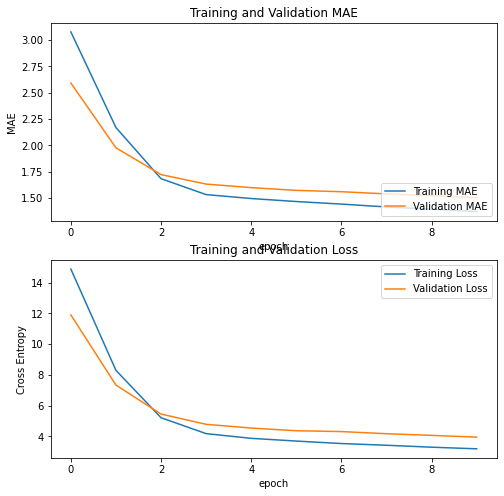

In [15]:
mae = history.history['mae']
val_mae = history.history['val_mae']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(mae, label='Training MAE')
plt.plot(val_mae, label='Validation MAE')
plt.legend(loc='lower right')
plt.xlabel('epoch')
plt.ylabel('MAE')
plt.title('Training and Validation MAE')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.xlabel('epoch')
plt.ylabel('Cross Entropy')
plt.title('Training and Validation Loss')
plt.show()

# Model 3 (Resnet)

In [16]:
preprocess_input = tf.keras.applications.resnet.preprocess_input

IMG_SHAPE = (image_height, image_width) + (3,)
base_model = ResNet50(input_shape=IMG_SHAPE,
                      include_top=False,
                      weights='imagenet')



normalization_layer = layers.Rescaling(1./255)
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
feature_batch = base_model(image_batch)

base_model.trainable = False
base_model.summary()

94781440/94765736 [==============================] - 1s 0us/step
Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_5[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                          

In [17]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)

prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)

In [18]:
inputs = tf.keras.Input(shape=IMG_SHAPE)
# x = data_augmentation(inputs)
x = preprocess_input(inputs)
x = base_model(x, training=False)
x = global_average_layer(x)
# x = layers.Dropout(0.2)(x)
outputs = layers.Dense(1, activation='linear')(x)

model = tf.keras.Model(inputs, outputs)

In [19]:
base_learning_rate = 0.0001
model.compile(optimizer = tf.keras.optimizers.RMSprop(lr=base_learning_rate),
              loss = 'mse',
              metrics = ['mae'])

model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.__operators__.getitem_2   (None, 224, 224, 3)      0         
 (SlicingOpLambda)                                               
                                                                 
 tf.nn.bias_add_2 (TFOpLambd  (None, 224, 224, 3)      0         
 a)                                                              
                                                                 
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d_2   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                           

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


In [20]:
initial_epochs = 10

history = model.fit_generator(train_ds,
                              epochs=initial_epochs,
                              validation_data=val_ds)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  """


Epoch 1/10
26/26 [==============================] - 14s 361ms/step - loss: 2.5525 - mae: 1.2934 - val_loss: 1.5518 - val_mae: 0.9853
Epoch 2/10
26/26 [==============================] - 8s 273ms/step - loss: 1.4020 - mae: 0.9446 - val_loss: 1.4051 - val_mae: 0.9482
Epoch 3/10
26/26 [==============================] - 8s 273ms/step - loss: 1.2408 - mae: 0.8942 - val_loss: 1.3188 - val_mae: 0.9314
Epoch 4/10
26/26 [==============================] - 7s 272ms/step - loss: 1.1087 - mae: 0.8509 - val_loss: 1.1974 - val_mae: 0.8903
Epoch 5/10
26/26 [==============================] - 8s 273ms/step - loss: 1.0055 - mae: 0.8136 - val_loss: 1.1336 - val_mae: 0.8710
Epoch 6/10
26/26 [==============================] - 8s 274ms/step - loss: 0.9262 - mae: 0.7856 - val_loss: 1.0599 - val_mae: 0.8279
Epoch 7/10
26/26 [==============================] - 7s 272ms/step - loss: 0.8651 - mae: 0.7562 - val_loss: 1.0375 - val_mae: 0.8357
Epoch 8/10
26/26 [==============================] - 8s 278ms/step - loss: 0

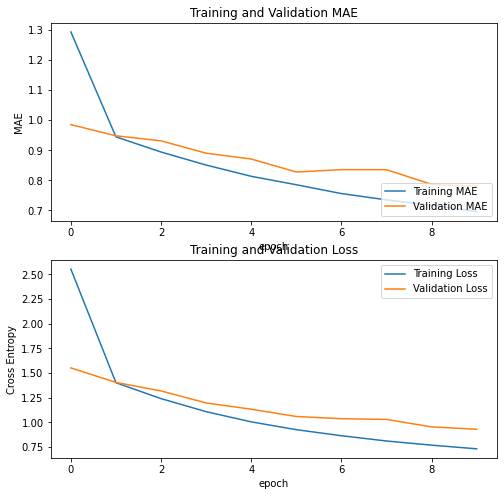

In [21]:
mae = history.history['mae']
val_mae = history.history['val_mae']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(mae, label='Training MAE')
plt.plot(val_mae, label='Validation MAE')
plt.legend(loc='lower right')
plt.xlabel('epoch')
plt.ylabel('MAE')
plt.title('Training and Validation MAE')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.xlabel('epoch')
plt.ylabel('Cross Entropy')
plt.title('Training and Validation Loss')
plt.show()